In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold

import numpy as np
from scipy import stats
from scipy.stats import norm, skew, boxcox  #for some statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics import make_scorer, mean_squared_error
from scipy.special import boxcox1p

In [8]:
dattest = pd.read_csv("C:/Users/Nick/Python/House Prices/test.csv")
dattrain = pd.read_csv("C:/Users/Nick/Python/House Prices/train.csv")

test_id = dattest['Id']
#Target = dattrain['SalePrice']

In [9]:
dattrain['Train_Test'] = 'Train'
dattest['Train_Test'] = 'Test'
full_data = [dattrain,dattest]


In [10]:
dattrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Train_Test
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,Train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,Train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,Train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,Train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,Train


In [11]:
dattest.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Train_Test
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,Test
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,Test
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,Test
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,Test
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,Test


In [12]:
dattrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Train_Test
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,Train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,Train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,Train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,Train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,Train


In [13]:
null_list = dattrain.isnull().sum(axis=0) ## sum of all the nulls. Store them in a pandas series object
null_df = pd.DataFrame(null_list) ## Convert to data frame so we can easily filter
null_df[null_df[0] > 0] ## Show only the columns with nulls

,0
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In [14]:
dattrain.describe(include = "all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Train_Test
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000,1460
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,3,4,4,NaN,NaN,NaN,9,6,NaN,1
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN,Train
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,3,157,49,NaN,NaN,NaN,1267,1198,NaN,1460
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890,NaN
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883,NaN
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000,NaN
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000,NaN
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000,NaN
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000,NaN


## Exploratory Analysis

### Target Variable: Sale Price


Since this is a regression problem, its important to check the whether or not the data is normally distributed. In this case, since we are dealing with sales prices (that theoretically should not be below zero dollars), we will most likely observe a right skew.

Code Credit: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


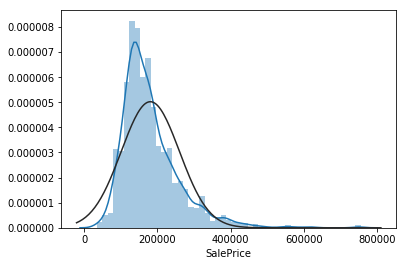

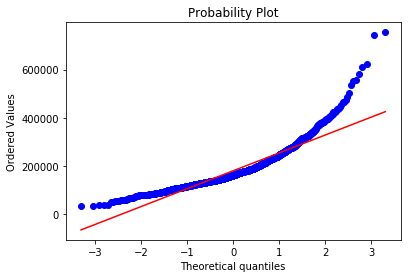

In [15]:
sns.distplot(dattrain['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['SalePrice'], plot=plt)

In [16]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
dattrain['SalePrice'] = np.log1p(dattrain['SalePrice'])
Target = dattrain['SalePrice']

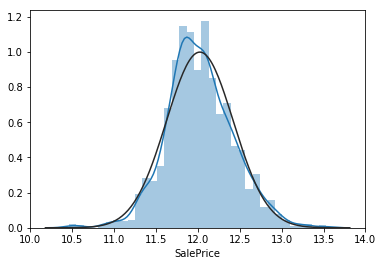

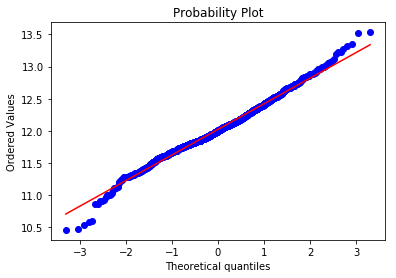

In [17]:
sns.distplot(dattrain['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['SalePrice'], plot=plt)

Looks like that took care of a making the sale price more normal. We will have to convert it back after we have predicted it.

### TotalBsmtSF

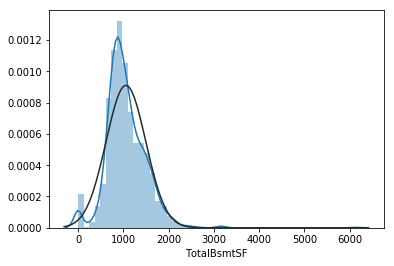

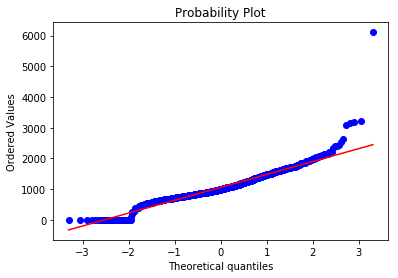

In [18]:
sns.distplot(dattrain['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['TotalBsmtSF'], plot=plt)

TotalBsmtSF has some issues since 0 means that people do not have a basement. We want to preserve this, so we leverage this online tutorial: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python


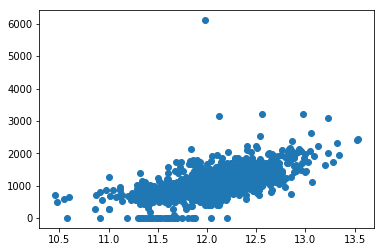

In [19]:
plt.scatter('SalePrice','TotalBsmtSF', data = dattrain)

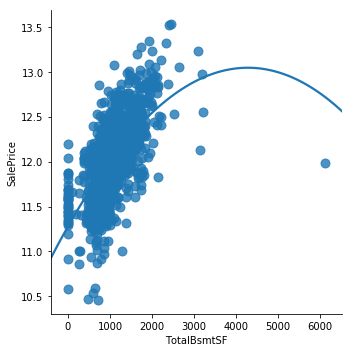

In [20]:
sns.lmplot(x='TotalBsmtSF', y='SalePrice', data=dattrain,
           order=2, ci=None, scatter_kws={"s": 80});

In [21]:
dattrain['TotalBsmtSFSquare'] = dattrain['TotalBsmtSF']**2

### 2ndFlrSF

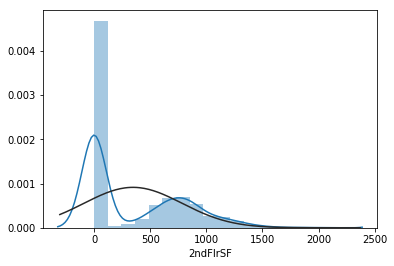

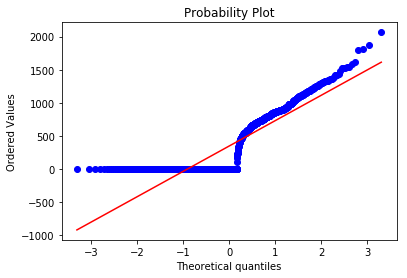

In [22]:
sns.distplot(dattrain['2ndFlrSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['2ndFlrSF'], plot=plt)

This is interesting. Here we show what looks like two normal distributions. If people have a 2nd floor, t

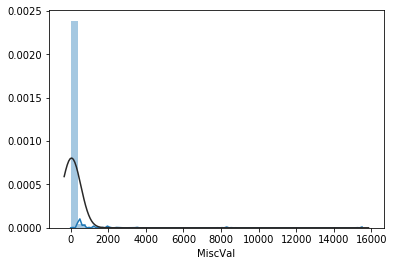

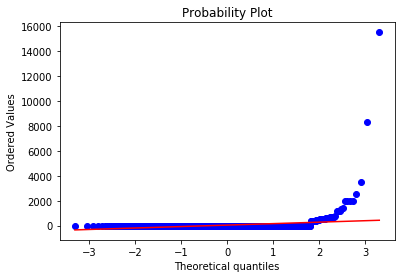

In [23]:
sns.distplot((dattrain['MiscVal']), fit=norm);
fig = plt.figure()
res = stats.probplot((dattrain['MiscVal']), plot=plt)

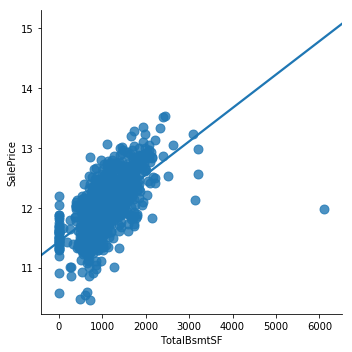

In [24]:
sns.lmplot(x='TotalBsmtSF', y='SalePrice', data=dattrain,
           order=1, ci=None, scatter_kws={"s": 80});

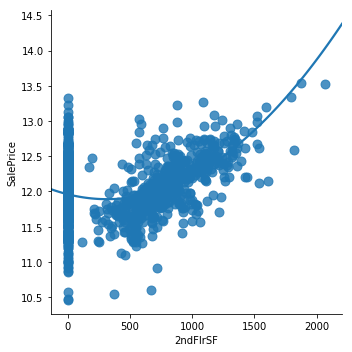

In [25]:
sns.lmplot(x='2ndFlrSF', y='SalePrice', data=dattrain,
           order=2, ci=None, scatter_kws={"s": 80});

In [26]:
dattrain['2ndFlrSFSquare'] = dattrain['2ndFlrSF']**2
dattest['2ndFlrSFSquare'] = dattest['2ndFlrSF']**2

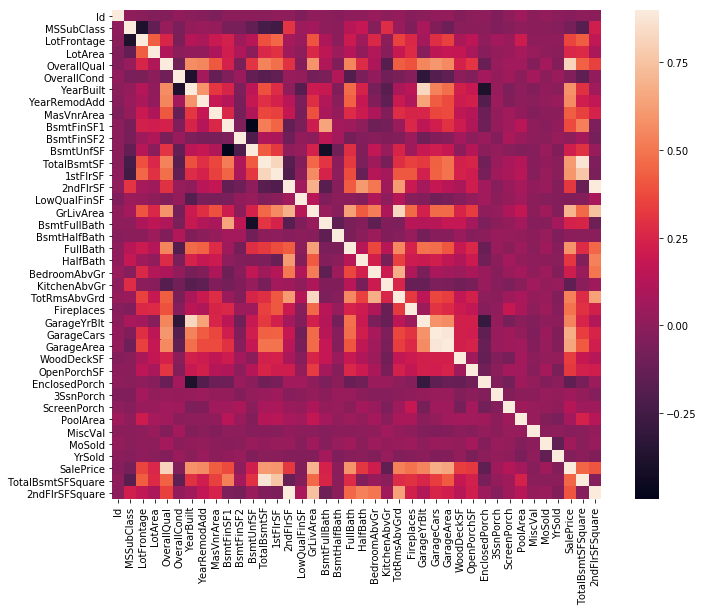

In [27]:
#Correlation map to see how features are correlated with SalePrice
corrmat = dattrain.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

# Categorical Variables


### MSSubClass:

This field has numeric dummy variables in it. As we review the data_description file corresponds to:


    20  1-STORY 1946 & NEWER ALL STYLES
    30  1-STORY 1945 & OLDER
    40  1-STORY W/FINISHED ATTIC ALL AGES
    45  1-1/2 STORY - UNFINISHED ALL AGES
    50  1-1/2 STORY FINISHED ALL AGES
    60  2-STORY 1946 & NEWER
    70  2-STORY 1945 & OLDER
    75  2-1/2 STORY ALL AGES
    80  SPLIT OR MULTI-LEVEL
    85  SPLIT FOYER
    90  DUPLEX - ALL STYLES AND AGES
    120  1-STORY PUD (Planned Unit Development) - 1946 & NEWER
    150  1-1/2 STORY PUD - ALL AGES
    160  2-STORY PUD - 1946 & NEWER
    180  PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
    190  2 FAMILY CONVERSION - ALL STYLES AND AGES



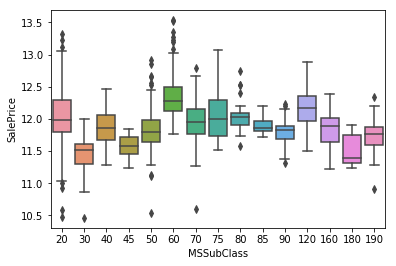

In [28]:
dattrain['MSSubClass']
sns.boxplot(x= 'MSSubClass', y = 'SalePrice', data = dattrain)

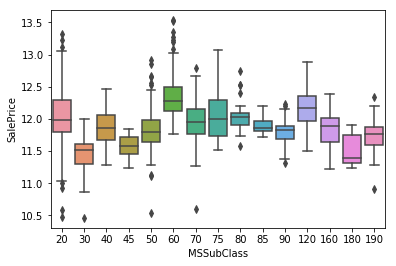

In [29]:
sns.boxplot(x = "MSSubClass", y = "SalePrice", data =dattrain)

Looks like this is a categorical variable that was made numeric. Let's transform the variable back to text and then one-hot encode it like the other categorical variables

In [30]:
## Convert the MSSubClass from numeric so we can more easily understand the labels as we do one-hot encoding later
mapping = { 20: "1-STORY 1946 & NEWER ALL STYLES" 
           , 30 : "1-STORY 1945 & OLDER"
           , 40 : "1-STORY W/FINISHED ATTIC ALL AGES"
           , 45 : "1-1/2 STORY - UNFINISHED ALL AGES"
           , 50 : "1-1/2 STORY FINISHED ALL AGES"
           , 60 : "2-STORY 1946 & NEWER"
           , 70 : "2-STORY 1945 & OLDER"
           , 80 : "SPLIT OR MULTI-LEVEL"
           , 85 : "SPLIT FOYER"
           , 90 : "DUPLEX - ALL STYLES AND AGES"
           , 120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER"
           , 150: "1-1/2 STORY PUD - ALL AGES"
           , 180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER"
           , 190: "2 FAMILY CONVERSION - ALL STYLES AND AGES"
          }
for dataset in full_data:
    dataset['MSSubClass'] = dataset['MSSubClass'].map(mapping)
    dataset['MSSubClass'] = dataset['MSSubClass'].fillna(0)
    


### MsZoning
MSZoning: Identifies the general zoning classification of the sale.

    A    Agriculture
    C    Commercial
    FV   Floating Village Residential
    I    Industrial
    RH   Residential High Density
    RL   Residential Low Density
    RP   Residential Low Density Park 
    RM   Residential Medium Density

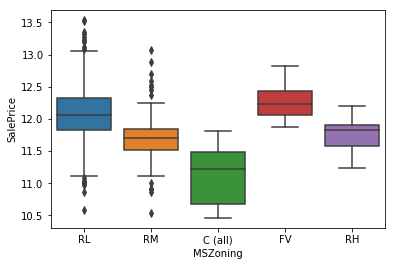

In [31]:
sns.boxplot(x = "MSZoning", y = "SalePrice", data =dattrain)

Looks like a categorical variable that we will address with One-Hot Encoding

### LotFrontage

LotFrontage: Linear feet of street connected to property



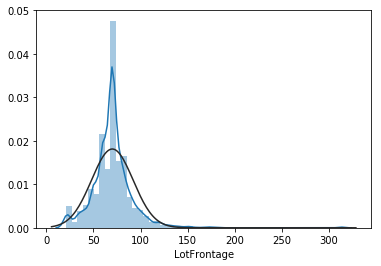

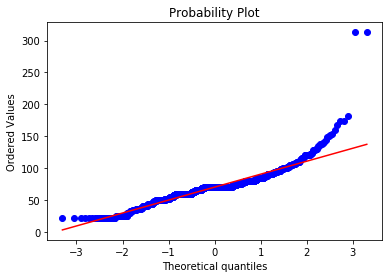

In [32]:
dattrain['LotFrontage'] = dattrain['LotFrontage'].fillna(dattrain['LotFrontage'].mean()) ## impute the nulls with the mean
sns.distplot((dattrain['LotFrontage']), fit=norm);
fig = plt.figure()
res = stats.probplot((dattrain['LotFrontage']), plot=plt)

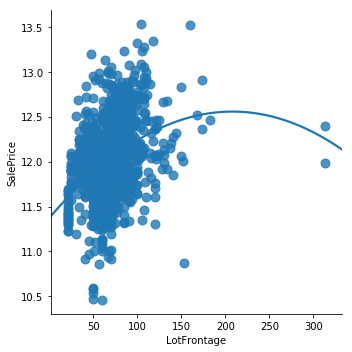

In [33]:
sns.lmplot(x='LotFrontage', y='SalePrice', data=dattrain,
           order=2, ci=None, scatter_kws={"s": 80});

In [34]:
dattrain['LotFrontageSquare'] = dattrain['LotFrontage']**2
dattest['LotFrontageSquare'] = dattest['LotFrontage']**2

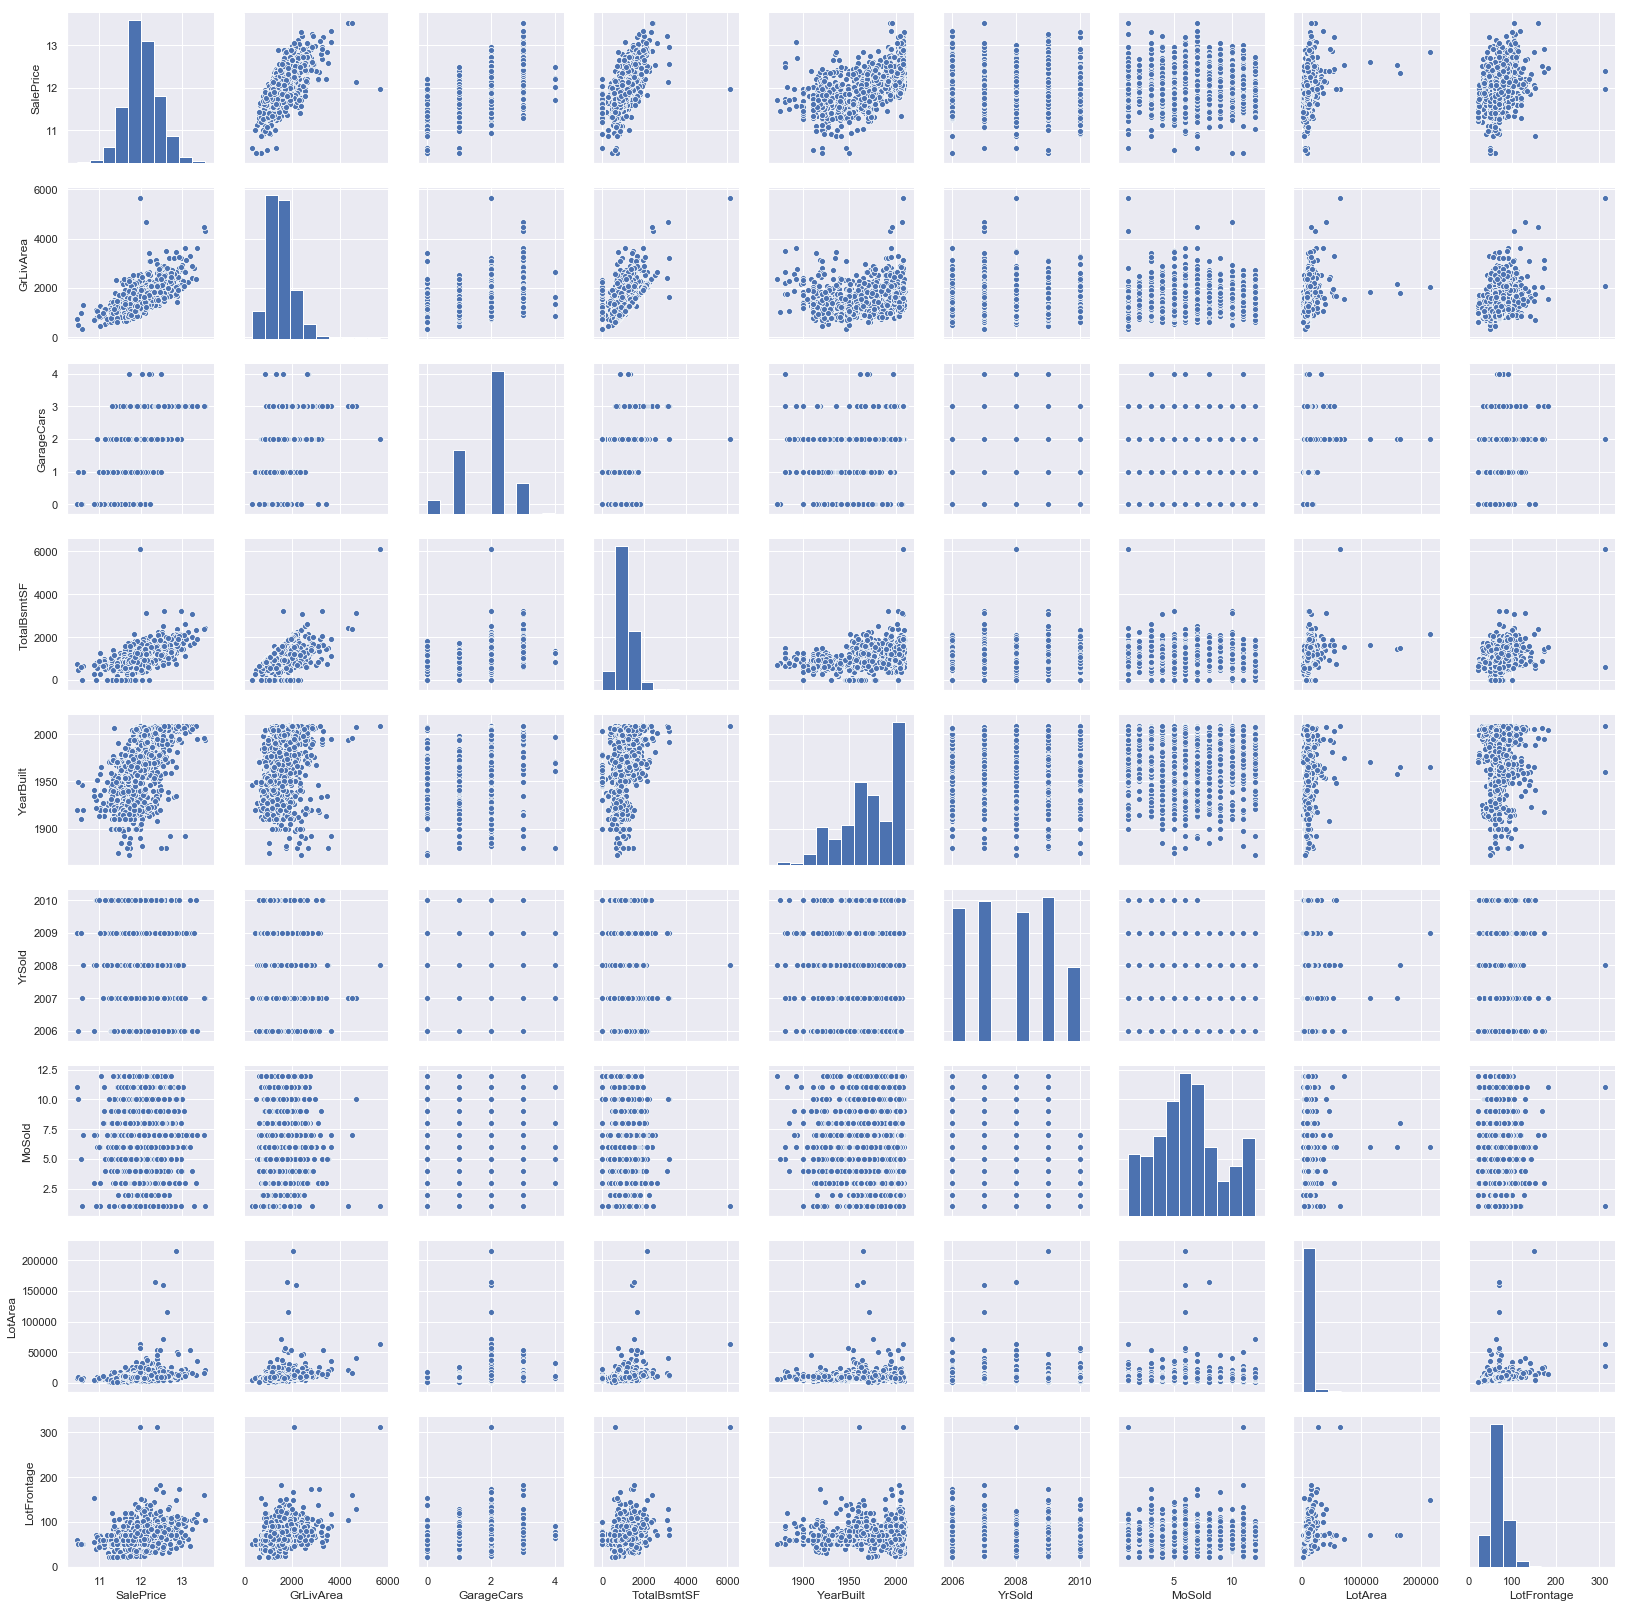

In [35]:
#scatterplot
sns.set()
cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'YrSold', 'MoSold', 'LotArea','LotFrontage']
sns.pairplot(dattrain[cols], height = 2.5)
plt.show();

### Street
Street: Type of road access to property

    Grvl Gravel  
    Pave Paved

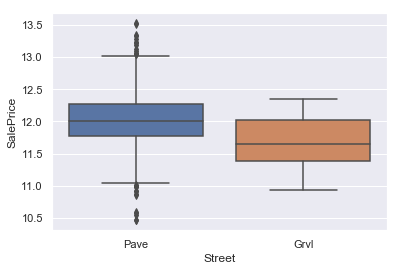

In [36]:
sns.boxplot(x = "Street", y = "SalePrice", data =dattrain)

In [37]:
mapping = { "Pave": 1, "Grvl": 0}
for dataset in full_data:
    dataset['Street'] = dataset['Street'].map(mapping)
    dataset['Street'] = dataset['Street'].fillna(0) ## Make any nulls gravl

### Alley 
Alley: Type of alley access to property

    Grvl Gravel
    Pave Paved
    NA   No alley access

Looks like the NA's here are representative of a class. We will handle that when we do feature engineering

In [38]:
dattrain['Alley'] = dattrain['Alley'].fillna('NoAlley')
dattest['Alley']  = dattest['Alley'].fillna('NoAlley')

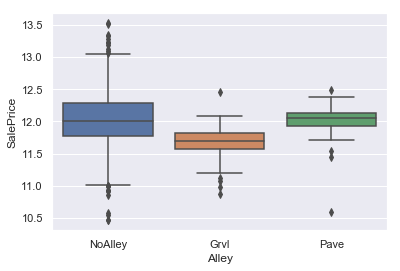

In [39]:
sns.boxplot(x = "Alley", y = "SalePrice", data =dattrain)

Since we have three classes of this categorical variable, we will one-hot encode them with the rest later

### LotShape
LotShape: General shape of property

    Reg  Regular 
    IR1  Slightly irregular
    IR2  Moderately Irregular
    IR3  Irregular

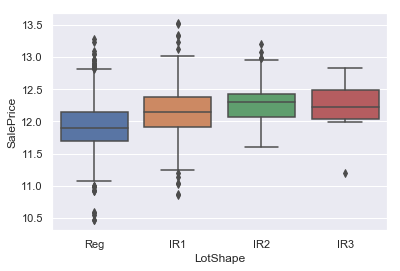

In [40]:
sns.boxplot(x = "LotShape", y = "SalePrice", data =dattrain)

Looks like order matters here. We will encode with regular being the lowest and IR3 being the highest

In [41]:
## Convert the Lotshape to numeric so models can handle them appropriately
lotshape_mapping = { "Reg": 1, "IR1": 2, "IR2":3, "IR3":4}
for dataset in full_data:
    dataset['LotShape'] = dataset['LotShape'].map(lotshape_mapping)
    dataset['LotShape'] = dataset['LotShape'].fillna(0)


### LandContour
LandContour: Flatness of the property

    Lvl  Near Flat/Level 
    Bnk  Banked - Quick and significant rise from street grade to building
    HLS  Hillside - Significant slope from side to side
    Low  Depression

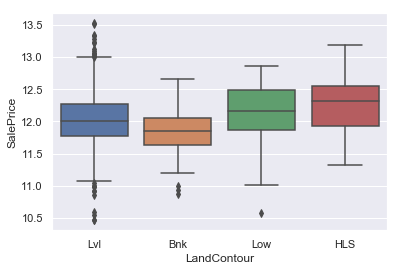

In [42]:
sns.boxplot(x = "LandContour", y = "SalePrice", data =dattrain)

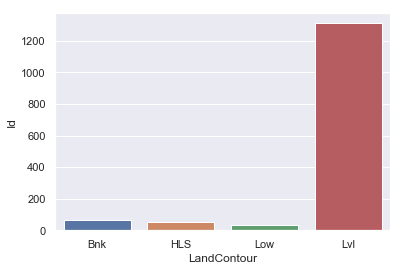

In [43]:
a = dattrain[['LandContour','Id']].groupby(['LandContour'], as_index = False).count()
sns.barplot(x = 'LandContour', y = 'Id', data = a)

Looks most of the lots are leveled. Given the limited variability in this items, lets drop it for now


In [44]:
drop_elements = ['LandContour']


dattrain = dattrain.drop(drop_elements, axis = 1)
dattest = dattest.drop(drop_elements, axis = 1)

### Utilities

Utilities: Type of utilities available

    AllPub   All public Utilities (E,G,W,& S)    
    NoSewr   Electricity, Gas, and Water (Septic Tank)
    NoSeWa   Electricity and Gas Only
    ELO  Electricity only  
   
Looks like most of the utilities are all public.. Drop this variable

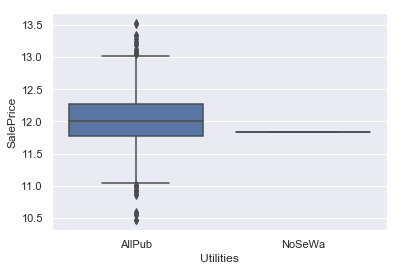

In [45]:
sns.boxplot(x = "Utilities", y = "SalePrice", data =dattrain)

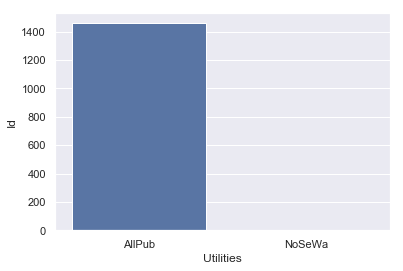

In [46]:
a = dattrain[['Utilities','Id']].groupby(['Utilities'], as_index = False).count()
sns.barplot(x = 'Utilities', y = 'Id', data = a)

Very few records that are not all public. Let's drop it

In [47]:
drop_elements = ['Utilities']


dattrain = dattrain.drop(drop_elements, axis = 1)
dattest = dattest.drop(drop_elements, axis = 1)

### LotConfig

LotConfig: Lot configuration

    Inside   Inside lot
    Corner   Corner lot
    CulDSac  Cul-de-sac
    FR2  Frontage on 2 sides of property
    FR3  Frontage on 3 sides of property

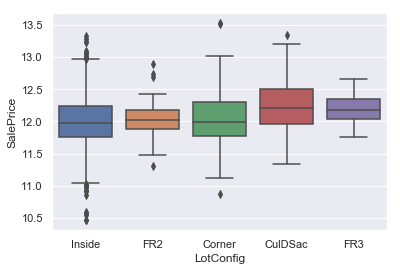

In [48]:
sns.boxplot(x = "LotConfig", y = "SalePrice", data =dattrain)

Looks like a categorical variable without any order. We will one-hot encode with the rest later.

### Landslope
LandSlope: Slope of property

    Gtl  Gentle slope
    Mod  Moderate Slope  
    Sev  Severe Slope

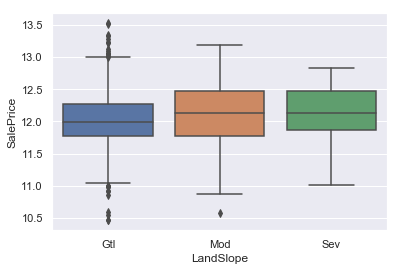

In [49]:
sns.boxplot(x = "LandSlope", y = "SalePrice", data =dattrain)

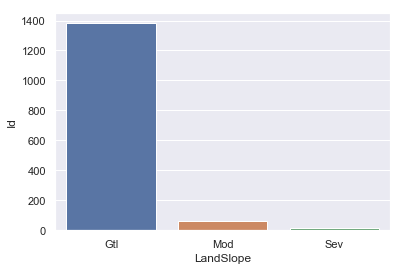

In [50]:
a = dattrain[['LandSlope','Id']].groupby(['LandSlope'], as_index = False).count()
sns.barplot(x = 'LandSlope', y = 'Id', data = a)

Looks like there is order here with gentle being the lowest and severe being the highest.


In [51]:
## Convert the Landslope to numeric so models can handle them appropriately
mapping = { "Gtl": 1, "Mod": 2, "Sev":3}
for dataset in full_data:
    dataset['LandSlope'] = dataset['LandSlope'].map(mapping)
    dataset['LandSlope'] = dataset['LandSlope'].fillna(1)

### Neighborhood
Neighborhood: Physical locations within Ames city limits

    Blmngtn  Bloomington Heights
    Blueste  Bluestem
    BrDale   Briardale
    BrkSide  Brookside
    ClearCr  Clear Creek
    CollgCr  College Creek
    Crawfor  Crawford
    Edwards  Edwards
    Gilbert  Gilbert
    IDOTRR   Iowa DOT and Rail Road
    MeadowV  Meadow Village
    Mitchel  Mitchell
    Names    North Ames
    NoRidge  Northridge
    NPkVill  Northpark Villa
    NridgHt  Northridge Heights
    NWAmes   Northwest Ames
    OldTown  Old Town
    SWISU    South & West of Iowa State University
    Sawyer   Sawyer
    SawyerW  Sawyer West
    Somerst  Somerset
    StoneBr  Stone Brook
    Timber   Timberland
    Veenker  Veenker

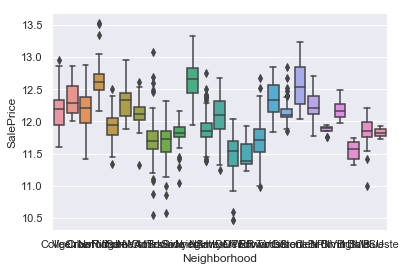

In [52]:
sns.boxplot(x = "Neighborhood", y = "SalePrice", data =dattrain)

Looks like neighborhood has an impact on house price. Let's include it an use one-hot encoding for it.

### Condition 1 and Condition 2

These fields are very similar. I haven't figured out how to combine them and maybe one-hot encode each of them so I will drop them for now.


Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

In [53]:
drop_elements = ['Condition1', 'Condition2']


dattrain = dattrain.drop(drop_elements, axis = 1)
dattest = dattest.drop(drop_elements, axis = 1)

### BldgType


BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

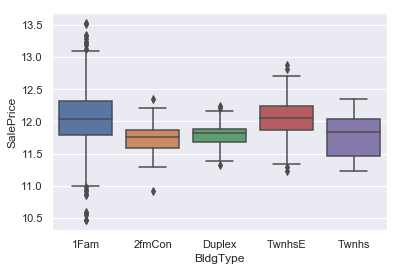

In [54]:
sns.boxplot(x = "BldgType", y = "SalePrice", data =dattrain)

Categorical.. Let's one-hot encode for now.

### RoofStyle
RoofStyle: Type of roof

    Flat Flat
    Gable    Gable
    Gambrel  Gabrel (Barn)
    Hip  Hip
    Mansard  Mansard
    Shed Shed

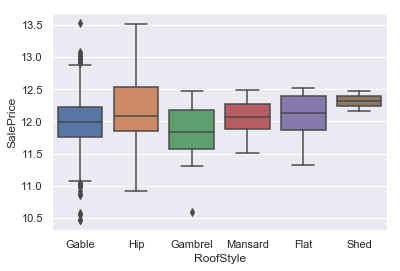

In [55]:
sns.boxplot(x = "RoofStyle", y = "SalePrice", data =dattrain)

Categorical.. Let's one-hot encode for now.

### SaleType

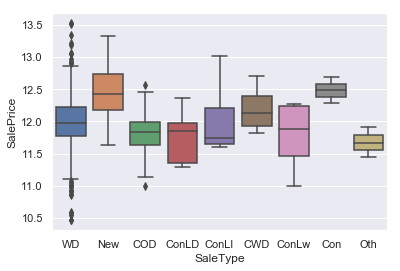

In [56]:
sns.boxplot(x = "SaleType", y = "SalePrice", data =dattrain)

Categorical.. Let's one-hot encode for now.

### SaleCondition

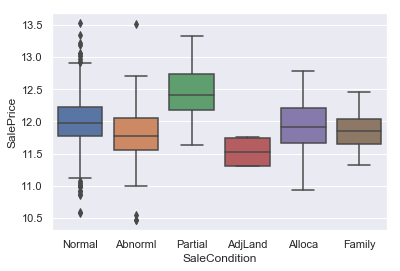

In [57]:
sns.boxplot(x = "SaleCondition", y = "SalePrice", data =dattrain)

Categorical... Let's one-hot encode for now

### HeatingQC

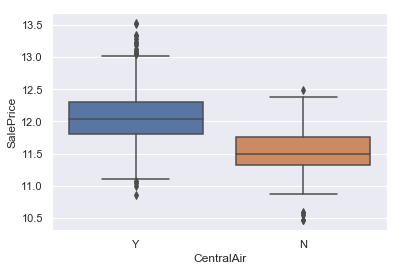

In [58]:
sns.boxplot(x = "CentralAir", y = "SalePrice", data =dattrain)

In [59]:
## Convert the Central Air to numeric so models can handle them appropriately
mapping = { "Y": 1, "N": 0}
for dataset in full_data:
    dataset['CentralAir'] = dataset['CentralAir'].map(mapping)
    dataset['CentralAir'] = dataset['CentralAir'].fillna(0)

### ExterCond


In [60]:
## Convert the ExterCond to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['ExterCond'] = dataset['ExterCond'].map(mapping)
    dataset['ExterCond'] = dataset['ExterCond'].fillna(0)
    
    


### ExterQual

In [61]:
## Convert the ExterQual to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['ExterQual'] = dataset['ExterQual'].map(mapping)
    dataset['ExterQual'] = dataset['ExterQual'].fillna(0)
    

### BsmtQual

In [62]:
## Convert the BsmtQual to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['BsmtQual'] = dataset['BsmtQual'].map(mapping)
    dataset['BsmtQual'] = dataset['BsmtQual'].fillna(0)

### BsmtCond

In [63]:
## Convert the BsmtCond to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['BsmtCond'] = dataset['BsmtCond'].map(mapping)
    dataset['BsmtCond'] = dataset['BsmtCond'].fillna(0)

### BsmtExposure

In [64]:
## Convert the BsmtExposure_ to numeric so models can handle them appropriately
mapping = {  "Gd": 4, "Av" :3 , "Mn" :2 , "No":1}
for dataset in full_data:
    dataset['BsmtExposure'] = dataset['BsmtExposure'].map(mapping)
    dataset['BsmtExposure'] = dataset['BsmtExposure'].fillna(0)

### HeatingQC

In [65]:
## Convert the HeatingQC to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['HeatingQC'] = dataset['HeatingQC'].map(mapping)
    dataset['HeatingQC'] = dataset['HeatingQC'].fillna(0)

### KitchenQual

In [66]:
## Convert the KitchenQual to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['KitchenQual'] = dataset['KitchenQual'].map(mapping)
    dataset['KitchenQual'] = dataset['KitchenQual'].fillna(0)

### FireplaceQu

In [67]:
## Convert the FireplaceQu to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['FireplaceQu'] = dataset['FireplaceQu'].map(mapping)
    dataset['FireplaceQu'] = dataset['FireplaceQu'].fillna(0)

### GarageQual

In [68]:
## Convert the GarageQual to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['GarageQual'] = dataset['GarageQual'].map(mapping)
    dataset['GarageQual'] = dataset['GarageQual'].fillna(0)

### GarageCond

In [69]:
## Convert the GarageCond to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['GarageCond'] = dataset['GarageCond'].map(mapping)
    dataset['GarageCond'] = dataset['GarageCond'].fillna(0)

### PoolQC

In [70]:
## Convert the PoolQC to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['PoolQC'] = dataset['PoolQC'].map(mapping)
    dataset['PoolQC'] = dataset['PoolQC'].fillna(0)

### Fence

In [71]:
## Convert the Fence to numeric so models can handle them appropriately
mapping = { "Ex": 5, "Gd": 4, "TA" :3 , "Fa" :2 , "Po":1}
for dataset in full_data:
    dataset['Fence'] = dataset['Fence'].map(mapping)
    dataset['Fence'] = dataset['Fence'].fillna(0)

### OverallQual

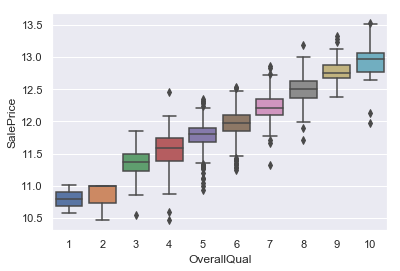

In [72]:
sns.boxplot(x = "OverallQual", y = "SalePrice", data =dattrain)

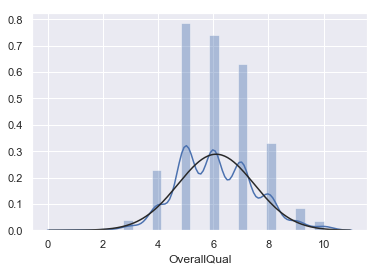

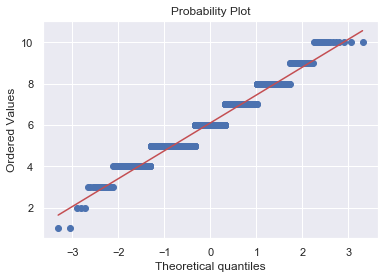

In [73]:
sns.distplot((dattrain['OverallQual']), fit=norm);
fig = plt.figure()
res = stats.probplot((dattrain['OverallQual']), plot=plt)

Looks like this numerical feature can stay the same. 

### OveralCond

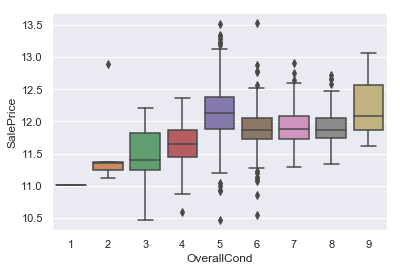

In [74]:
sns.boxplot(x = "OverallCond", y = "SalePrice", data =dattrain)

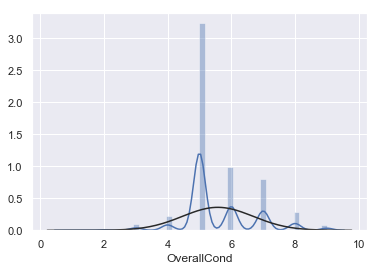

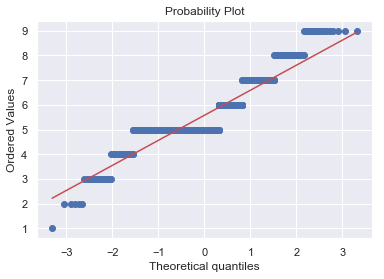

In [75]:
sns.distplot((dattrain['OverallCond']), fit=norm);
fig = plt.figure()
res = stats.probplot((dattrain['OverallCond']), plot=plt)

Let's keep this the way it is

### GarageFinish

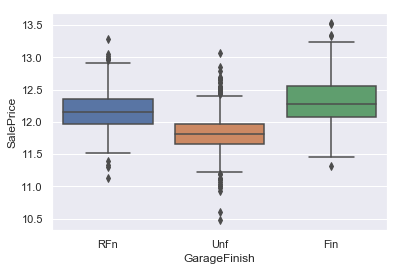

In [76]:
sns.boxplot(x = "GarageFinish", y = "SalePrice", data =dattrain)

Looks like the garage has three different levels of finished. Lets treat these as ordered

In [77]:
mapping = { "Fin": 3, "RFn": 2, "Unf":1}
for dataset in full_data:
    dataset['GarageFinish'] = dataset['GarageFinish'].map(mapping)
    dataset['GarageFinish'] = dataset['GarageFinish'].fillna(0)

In [78]:
### GarageType

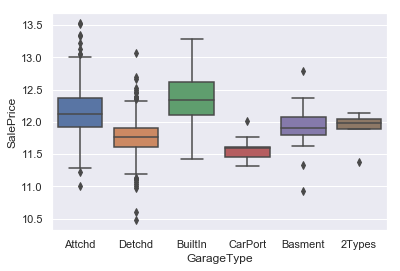

In [79]:
sns.boxplot(x = "GarageType", y = "SalePrice", data =dattrain)

Multiple different categories. Let's one-hot encode

### HouseStyle

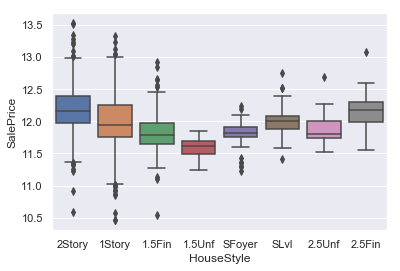

In [80]:
sns.boxplot(x = "HouseStyle", y = "SalePrice", data =dattrain)

Categorical.. One-hot encode

### RoofMatl

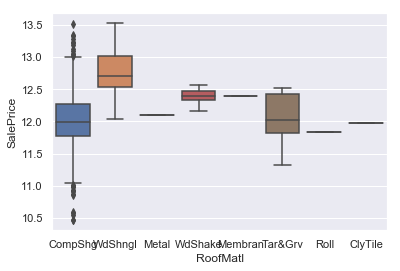

In [81]:
sns.boxplot(x = "RoofMatl", y = "SalePrice", data =dattrain)

Categorical.. One-hot

### BsmtFinType1

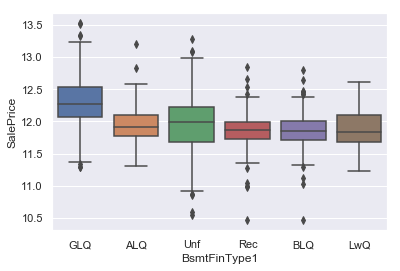

In [82]:
sns.boxplot(x = "BsmtFinType1", y = "SalePrice", data =dattrain)

Categorical.. one-hot

### BsmtFintype2

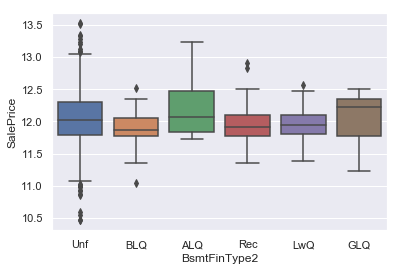

In [83]:
sns.boxplot(x = "BsmtFinType2", y = "SalePrice", data =dattrain)

Categorical.. one-hot

### BsmntFinSF1

In [84]:
for dataset in full_data:
    dataset['BsmtFinType1'] = dataset['BsmtFinType1'].fillna(0)

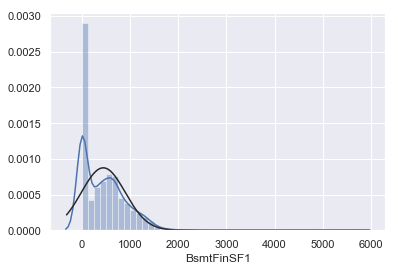

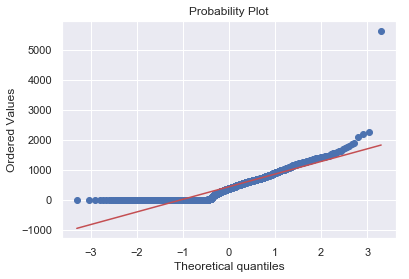

In [85]:
sns.distplot((dattrain['BsmtFinSF1']), fit=norm);
fig = plt.figure()
res = stats.probplot((dattrain['BsmtFinSF1']), plot=plt)

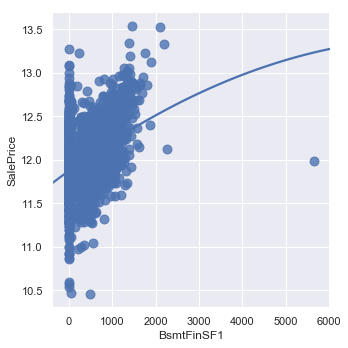

In [86]:
sns.lmplot(x='BsmtFinSF1', y='SalePrice', data=dattrain,
           order=2, ci=None, scatter_kws={"s": 80});

In [87]:
dattrain['BsmntFinSF1Square'] = dattrain['BsmtFinSF1']**2
dattest['BsmntFinSF1Square'] = dattest['BsmtFinSF1']**2

### BsmtFinType2

In [88]:
for dataset in full_data:
    dataset['BsmtFinType2'] = dataset['BsmtFinType2'].fillna(0)

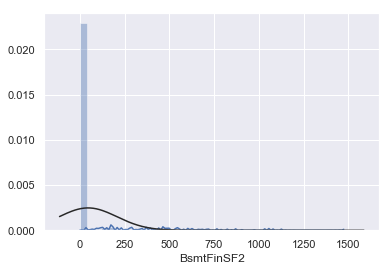

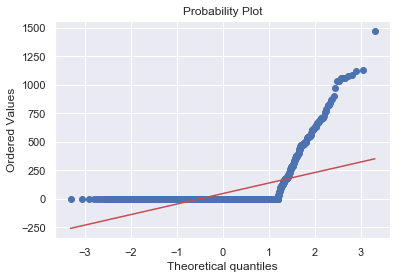

In [89]:
sns.distplot((dattrain['BsmtFinSF2']), fit=norm);
fig = plt.figure()
res = stats.probplot((dattrain['BsmtFinSF2']), plot=plt)

Remove NAs by making them zero. 

### BsmtUnfSF

In [90]:
for dataset in full_data:
    dataset['BsmtUnfSF'] = dataset['BsmtUnfSF'].fillna(0)

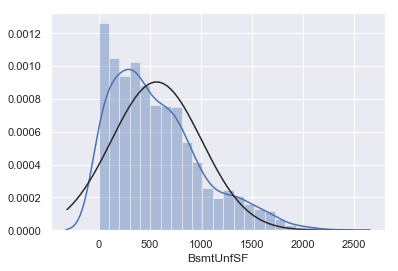

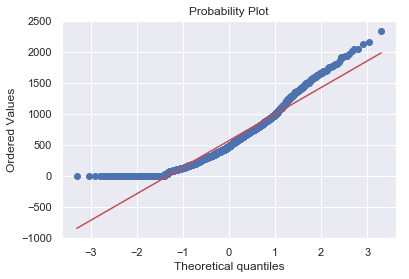

In [91]:
sns.distplot((dattrain['BsmtUnfSF']), fit=norm);
fig = plt.figure()
res = stats.probplot((dattrain['BsmtUnfSF']), plot=plt)

## Heating

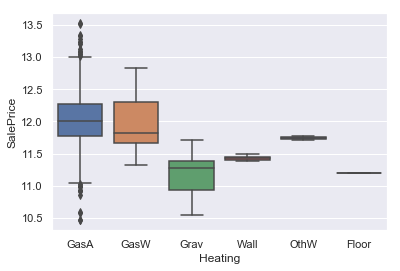

In [92]:
sns.boxplot(x = "Heating", y = "SalePrice", data =dattrain)

Categorical... Let's one-hot encode

### Electrical

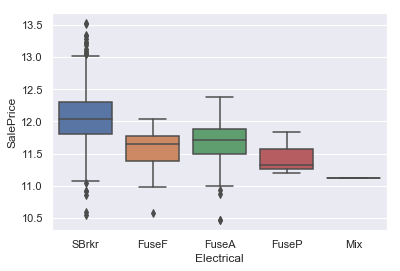

In [93]:
sns.boxplot(x = "Electrical", y = "SalePrice", data =dattrain)

Categorical... Let's one-hot encode

### Foundation

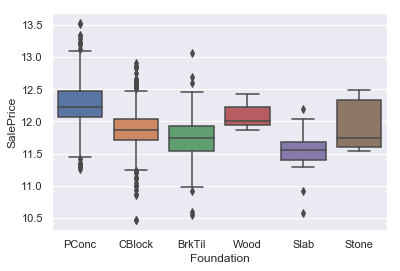

In [94]:
sns.boxplot(x = "Foundation", y = "SalePrice", data =dattrain)

Categorical... Let's one-hot encode

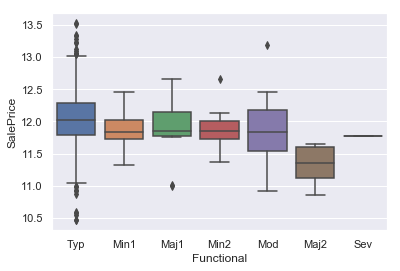

In [95]:
sns.boxplot(x = "Functional", y = "SalePrice", data =dattrain)

Looks like there should have been an order to this, but it doesn't seem to have a linear relationship with the target variable. Let's treat as categorical for now and one-hot

### MasVnrType

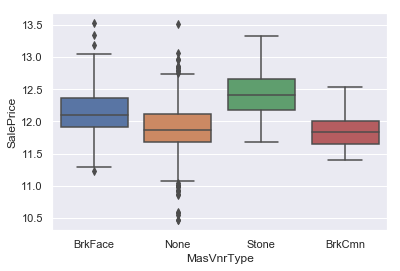

In [96]:
sns.boxplot(x = "MasVnrType", y = "SalePrice", data =dattrain)

Categorical.. one-hot

### MasVnrArea

In [97]:
### Remove nulls
for dataset in full_data:
    dataset['MasVnrArea'] = dataset['MasVnrArea'].fillna(0)

In [98]:
full_data =pd.concat(full_data,ignore_index = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### LotArea

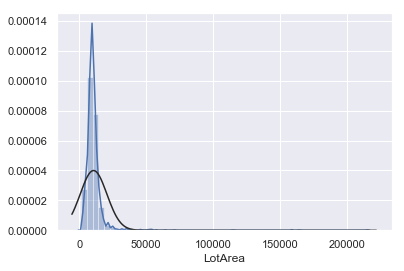

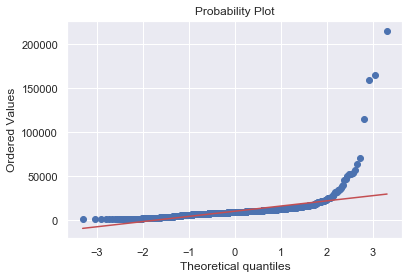

In [99]:
sns.distplot(dattrain['LotArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['LotArea'], plot=plt)

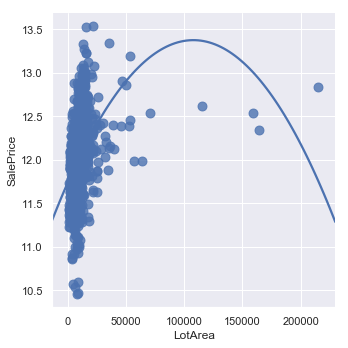

In [100]:
sns.lmplot(x='LotArea', y='SalePrice', data=dattrain,
           order=2, ci=None, scatter_kws={"s": 80});

In [101]:
dattrain['LotAreaSquare'] = dattrain['LotArea']**2
dattest['LotAreaSquare'] = dattest['LotArea']**2

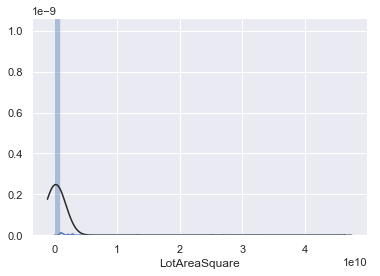

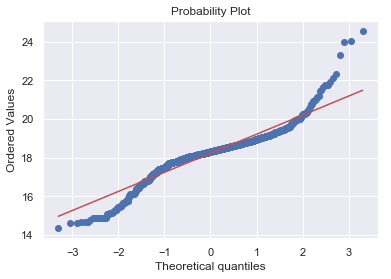

In [102]:
sns.distplot(dattrain['LotAreaSquare'], fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(dattrain['LotAreaSquare']), plot=plt)

Log Transform helps.. but introduces other issues that I am not really sure how to address at this point.


In [103]:
full_data['LotArea'] = np.log(full_data['LotArea'])

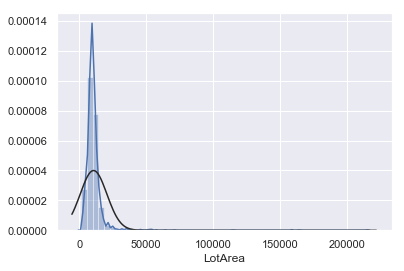

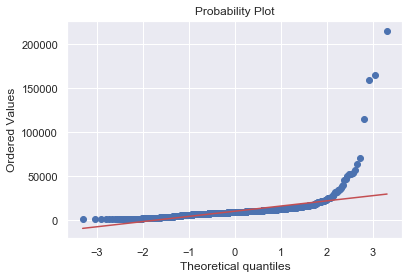

In [104]:
sns.distplot(dattrain['LotArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['LotArea'], plot=plt)

### GrLivArea

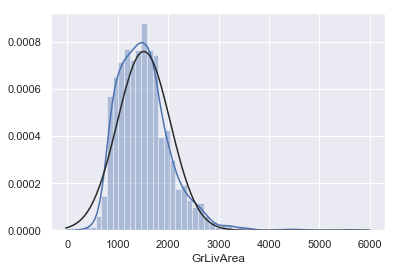

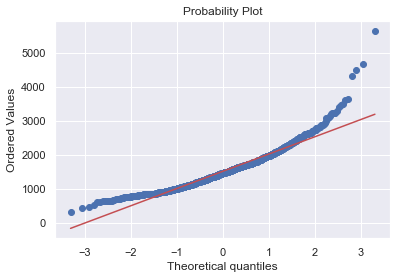

In [105]:
sns.distplot(dattrain['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['GrLivArea'], plot=plt)

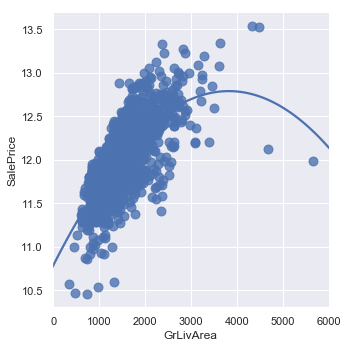

In [106]:
sns.lmplot(x='GrLivArea', y='SalePrice', data=dattrain,
           order=2, ci=None, scatter_kws={"s": 80});

In [107]:
### Create a squared variable
dattrain['GrvLivAreaSquare'] = dattrain['GrLivArea']**2
dattest['GrvLivAreaSquare'] = dattest['GrLivArea']**2

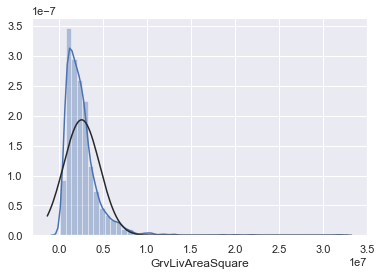

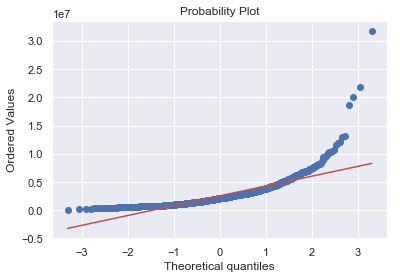

In [108]:
sns.distplot(dattrain['GrvLivAreaSquare'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['GrvLivAreaSquare'], plot=plt)

Log Transform it :)

In [109]:
full_data['GrLivArea'] = np.log(full_data['GrLivArea'])

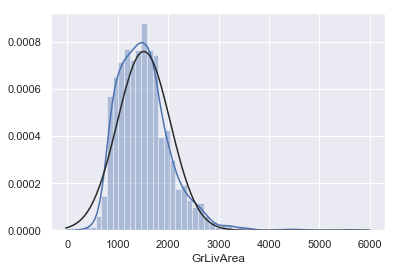

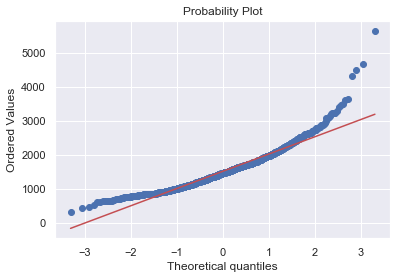

In [110]:
sns.distplot(dattrain['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['GrLivArea'], plot=plt)

### 1stFlrSF

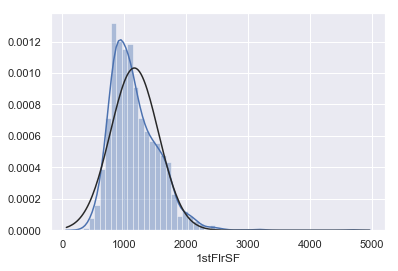

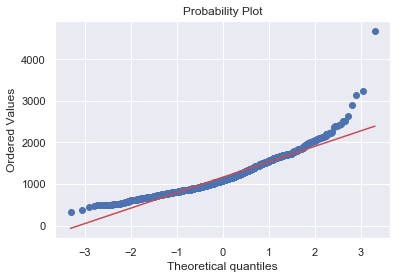

In [111]:
sns.distplot(dattrain['1stFlrSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['1stFlrSF'], plot=plt)

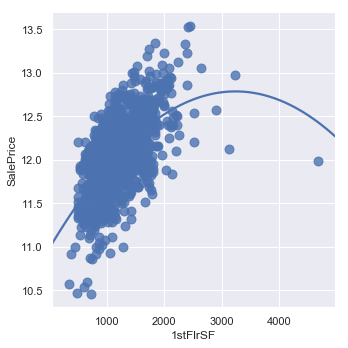

In [112]:
sns.lmplot(x='1stFlrSF', y='SalePrice', data=dattrain,
           order=2, ci=None, scatter_kws={"s": 80});

In [113]:
## Create a Squared Variable

dattrain['1stFlrSFSquare'] = dattrain['1stFlrSF']**2
dattest['1stFlrSFSquare'] = dattest['1stFlrSF']**2

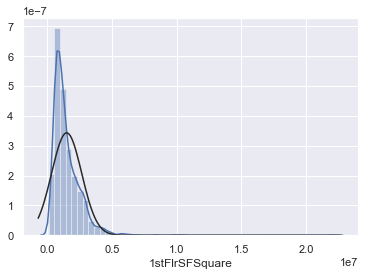

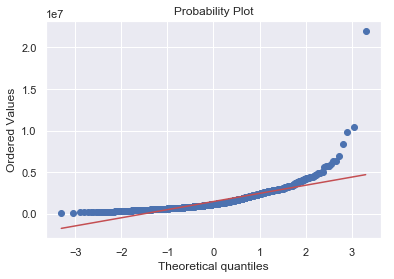

In [114]:
sns.distplot(dattrain['1stFlrSFSquare'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['1stFlrSFSquare'], plot=plt)

In [115]:
full_data['1stFlrSF'] = np.log(full_data['1stFlrSF'])

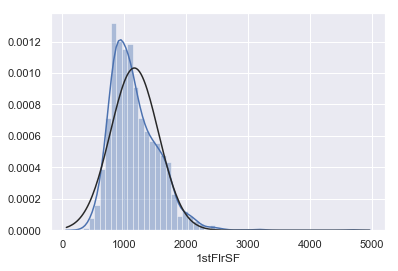

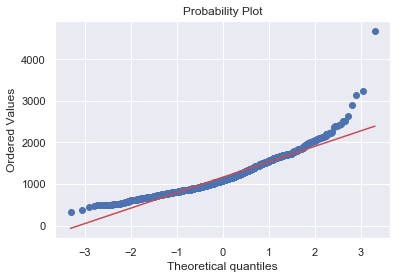

In [116]:
sns.distplot(dattrain['1stFlrSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(dattrain['1stFlrSF'], plot=plt)

In [117]:
full_data.head()

,1stFlrSF,2ndFlrSF,2ndFlrSFSquare,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,...,Street,TotRmsAbvGrd,TotalBsmtSF,TotalBsmtSFSquare,Train_Test,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,6.752270,854,729316,0,NoAlley,3,1Fam,3.0,1.0,706.0,...,1,8,856.0,732736.0,Train,AllPub,0,2003,2003,2008
1,7.140453,0,0,0,NoAlley,3,1Fam,3.0,4.0,978.0,...,1,6,1262.0,1592644.0,Train,AllPub,298,1976,1976,2007
2,6.824374,866,749956,0,NoAlley,3,1Fam,3.0,2.0,486.0,...,1,6,920.0,846400.0,Train,AllPub,0,2001,2002,2008
3,6.867974,756,571536,0,NoAlley,3,1Fam,4.0,1.0,216.0,...,1,7,756.0,571536.0,Train,AllPub,0,1915,1970,2006
4,7.043160,1053,1108809,0,NoAlley,4,1Fam,3.0,3.0,655.0,...,1,9,1145.0,1311025.0,Train,AllPub,192,2000,2000,2008


### Create Has Basement Variable

In [118]:
for row in full_data['BsmtQual']:
    if row == 0:
        full_data['HasBsmt'] = 0
    else:
        full_data['HasBsmt'] = 1

### Create Has Garage Variable

In [119]:
full_data['GarageArea'] = full_data['GarageArea'].fillna(0)

for row in full_data['GarageArea']:
    if row == 0:
        full_data['HasGarage'] = 0
    else:
        full_data['HasGarage'] = 1

### Create Has 2nd Floor Variable

In [120]:
for row in full_data['2ndFlrSF']:
    if row == 0:
        full_data['Has2ndFlr'] = 0
    else:
        full_data['Has2ndFlr'] = 1

In [121]:
full_data.head()

,1stFlrSF,2ndFlrSF,2ndFlrSFSquare,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,...,TotalBsmtSFSquare,Train_Test,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,HasBsmt,HasGarage,Has2ndFlr
0,6.752270,854,729316,0,NoAlley,3,1Fam,3.0,1.0,706.0,...,732736.0,Train,AllPub,0,2003,2003,2008,1,1,1
1,7.140453,0,0,0,NoAlley,3,1Fam,3.0,4.0,978.0,...,1592644.0,Train,AllPub,298,1976,1976,2007,1,1,1
2,6.824374,866,749956,0,NoAlley,3,1Fam,3.0,2.0,486.0,...,846400.0,Train,AllPub,0,2001,2002,2008,1,1,1
3,6.867974,756,571536,0,NoAlley,3,1Fam,4.0,1.0,216.0,...,571536.0,Train,AllPub,0,1915,1970,2006,1,1,1
4,7.043160,1053,1108809,0,NoAlley,4,1Fam,3.0,3.0,655.0,...,1311025.0,Train,AllPub,192,2000,2000,2008,1,1,1


In [122]:
numeric_feats = full_data.dtypes[full_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = full_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolQC,18.409137
PoolArea,16.898328
TotalBsmtSFSquare,12.696636
LowQualFinSF,12.088761
3SsnPorch,11.376065
LotFrontageSquare,9.279378
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.145323


In [131]:
## Boxcox transform all features that have a skew.

skewness = skewness[abs(skewness.Skew) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    full_data[feat] = boxcox1p(full_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 33 skewed numerical features to Box Cox transform


In [132]:
full_data = pd.get_dummies(full_data)

In [133]:
full_data['BsmtFinSF1'] = full_data['BsmtFinSF1'].fillna(0)
full_data['BsmtFinSF2'] = full_data['BsmtFinSF2'].fillna(0)
full_data['BsmtFullBath'] = full_data['BsmtFullBath'].fillna(0)
full_data['BsmtHalfBath'] = full_data['BsmtHalfBath'].fillna(0)

full_data['GarageCars'] = full_data['GarageCars'].fillna(0)
full_data['GarageYrBlt'] = full_data['GarageYrBlt'].fillna(0)
full_data['LotFrontage'] = full_data['LotFrontage'].fillna(0)
full_data['TotalBsmtSF'] = full_data['TotalBsmtSF'].fillna(0)


In [134]:
#dattrain = full_data.loc[full_data['Train_Test_Test'] == 1]
#dattest  = full_data.loc[full_data['Train_Test_Test'] == 0]

dattrain = full_data.loc[full_data['Id'] <1461]
dattest = full_data.loc[full_data['Id'] >1460]

##Target = dattrain['SalePrice'].copy
drop_elements = ['Train_Test_Train','SalePrice','Id']

dattrain = dattrain.drop(drop_elements, axis = 1)
dattest = dattest.drop(drop_elements, axis = 1)

## Modeling

In [135]:
X_train = dattrain
Y_train = Target
X_test = dattest
# Cross validate model with Kfold stratified cross val
kfold = KFold(n_splits=10, shuffle =True, random_state =42)

## Split Data into Train Test
X_train, X_test, Y_train, Y_test = train_test_split(dattrain,Target, test_size=0.3, random_state =29 )


In [136]:
X_csr = csr_matrix(X_train)
X_csr_test =csr_matrix(X_test)

In [137]:
X_dattrain_csr = csr_matrix(dattrain)
X_dattest_csr = csr_matrix(dattest)

In [138]:
# # fit model no training data
# model = xgb.XGBRegressor(n_estimators=10000, learning_rate=0.1)
# eval_set = [(X_csr_test, Y_test)]
# model.fit(X_csr, Y_train, eval_metric="rmse", eval_set=eval_set, verbose=False,early_stopping_rounds=20)
# ## make prediction for train data
# y_pred = model.predict(X_csr)
# predictions = y_pred
# # evaluate predictions
# rmse_train = mean_squared_error(Y_train, predictions)**(0.5)
# print("Train RMSE: %.2f%%" % (rmse_train))

# # make predictions for test data
# y_pred = model.predict(X_csr_test)
# predictions = y_pred
# # evaluate predictions
# rmse_test = mean_squared_error(Y_test, predictions)**(0.5)
# print("Test RMSE: %.2f%%" % (rmse_test))

In [139]:
# xgb_model = xgb.XGBRegressor()

# fit_parameters={"early_stopping_rounds":50, 
#             "eval_metric" : "rmse", 
#             "eval_set" : [[X_csr_test, Y_test]]}



# ## Search grid for optimal parameters
# xgb_param_grid = {"learning_rate": [0.1,0.05],
#               "n_estimators": [1000],
#               "max_depth": [4, 6, 10],
#               "subsample": [0.5,1],
#               "colsample_bytree": [0.5,0.8],
#               "nthread": [4],
#               "eval_metric": ["rmse"],
#               "seed": [1245]}


# gsxgb = GridSearchCV(xgb_model,param_grid = xgb_param_grid,fit_params = fit_parameters, cv=kfold, n_jobs= 4, verbose = 20 )
# gsxgb.fit(X_csr,Y_train)


# ## make prediction for train data
# y_pred = gsxgb.predict(X_csr)
# predictions = y_pred
# # evaluate predictions
# rmse_train = mean_squared_error(Y_train, predictions)**(0.5)
# print("Train RMSE: %.2f%%" % (rmse_train))



# # make predictions for test data
# y_pred = gsxgb.predict(X_csr_test)
# predictions = y_pred
# # evaluate predictions
# rmse_test = mean_squared_error(Y_test, predictions)**(0.5)
# print("Test RMSE: %.2f%%" % (rmse_test))


In [140]:
#gsxgb.best_params_

In [141]:
# log_Y_pred = gsxgb.predict(X_dattest_csr)
# Y_pred = np.expm1(log_Y_pred)

In [142]:
# submission = pd.DataFrame({ 'Id':test_id,'SalePrice':Y_pred,}) ## Need to make it a dictionary to combine the two
# submission.to_csv('House_Price_gsxgb_simplev3.csv', index=False)

In [143]:
xgb_model = xgb.XGBRegressor()

## Search grid for optimal parameters
xgb_param_grid = {"learning_rate": [0.01,0.05,0.3],
              "n_estimators": [400,600,1000],
              "max_depth": [3,6, 10],
              "min_child_weight": [1,6],
              "subsample": [0.5,0.8],
              "colsample_bytree": [0.5,0.9,1],
              "nthread": [4],
              "reg_alpha": [25,1,10],
              "reg_lambda":  [50,1,10],                
              "eval_metric": ["rmse"],
              "seed": [789]}


gsxgb = GridSearchCV(xgb_model,param_grid = xgb_param_grid, cv=kfold, n_jobs= 4, verbose = 1)




In [144]:
gsxgb.fit(X_dattrain_csr,Target)
log_Y_Pred = gsxgb.predict(X_dattest_csr)
Y_pred = np.expm1(log_Y_Pred)

Fitting 10 folds for each of 2916 candidates, totalling 29160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 12.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 20.2min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 29.2min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 42.9min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 51.0min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 62.4min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 77.9min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 90.6min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 102.6min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 117.7min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 140.

In [145]:
submission = pd.DataFrame({ 'Id':test_id,'SalePrice':Y_pred,}) ## Need to make it a dictionary to combine the two
submission.to_csv('House_Price_gsxgb_complex_v5.csv', index=False)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree= 0.4, eval_metric = 'rmse', gamma = 0.04, 
 learning_rate = 0.01, max_depth = 6, min_child_weight = 1.7, 
 n_estimators = 2500, nthread = 4, seed = 1245, subsample = 0.3)

model_xgb.fit(X_train, Y_train, eval_metric="rmse", eval_set=eval_set, verbose=True, early_stopping_rounds=50)


## make prediction for train data
y_pred = model_xgb.predict(X_train)
predictions = y_pred
# evaluate predictions
rmse_train = mean_squared_error(Y_train, predictions)**(0.5)
print("Train RMSE: %.2f%%" % (rmse_train))

# make predictions for test data
y_pred = model_xgb.predict(X_test)
predictions = y_pred
# evaluate predictions
rmse_test = mean_squared_error(Y_test, predictions)**(0.5)
print("Test RMSE: %.2f%%" % (rmse_test))